In [35]:
NOTEBOOK_NAME = "e009_check_same_test"

In [36]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import japanize_matplotlib

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from tqdm.auto import tqdm

%matplotlib inline


# ref: Kaggle„Ç≥„Éº„ÉâÈÅ∫Áî£ https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
# ÂÜçÁèæÊÄßÁ¢∫‰øù!
seed_everything(33)

In [37]:
INPUT_DIR = "../data"
OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [38]:
glob(os.path.join(INPUT_DIR, "*"))

['../data/train_log.csv',
 '../data/test_log.csv',
 '../data/image_embeddings.parquet',
 '../data/atmaCup16_Dataset.zip',
 '../data/train_label.csv',
 '../data/yado.csv',
 '../data/test_session.csv',
 '../data/sample_submission.csv']

In [39]:
sorted(glob(os.path.join(INPUT_DIR, "*")))

['../data/atmaCup16_Dataset.zip',
 '../data/image_embeddings.parquet',
 '../data/sample_submission.csv',
 '../data/test_log.csv',
 '../data/test_session.csv',
 '../data/train_label.csv',
 '../data/train_log.csv',
 '../data/yado.csv']

In [40]:
# Â≠¶ÁøíÁî®„ÅÆ„É≠„Ç∞„Éá„Éº„Çø„Å®Ê≠£Ëß£„É©„Éô„É´
train_log_df = pd.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label_df = pd.read_csv(os.path.join(INPUT_DIR, "train_label.csv"))

# ÂÆø„ÅÆ„Éá„Éº„Çø
yado_df = pd.read_csv(os.path.join(INPUT_DIR, "yado.csv"))

# „ÉÜ„Çπ„ÉàÊúüÈñì„ÅÆ„É≠„Ç∞„Éá„Éº„Çø
test_log_df = pd.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))

sample_submission_df = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))

In [41]:
# „Åô„Åπ„Å¶„ÅÆ„É≠„Ç∞„Éá„Éº„Çø„ÅØ„ÅÇ„Å®„ÅÇ„Å®ÂèÇÁÖß„Çí„Åô„Çã„ÅÆ„ÅßÂÖà„Å´‰Ωú„Å£„Å¶„Åä„Åç„Åæ„Åô.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

‰ªäÂõû„ÅÆË¨õÂ∫ß„Åß„ÅØ„ÄÅÂçòÁ¥î„Å´„É≠„Ç∞„Éá„Éº„Çø„Å´Âá∫Áèæ„Åô„ÇãÂÆø„ÅÆID„Å´„Åã„Çâ„É©„É≥„ÉÄ„É†„Å´ N=10 „Çí„Çµ„É≥„Éó„É´„Åô„Çã„Åì„Å®„Å´„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

„Åô„Åî„ÅèÊÑöÁõ¥„Å´ÂÆüË£Ö„Çí„Åô„Çã„Å®‰ª•‰∏ã„ÅÆ„Çà„ÅÜ„Å´„Å™„Çä„Åæ„Åô„ÄÇ

‰∏äË®ò„ÅØ„Çè„Åã„Çä„ÇÑ„Åô„Åï„ÅÆ„Åü„ÇÅ„Å´ for Êñá„ÅßË®òËºâ„Çí„Åó„Åæ„Åó„Åü„ÄÇ„Åü„Å†„Å°„Çá„Å£„Å®ÈÅÖ„ÅÑ (1ÂàÜ„Åê„Çâ„ÅÑ„Åã„Åã„Çã) „ÅÆ„ÅßÂ∞ë„ÅóÂ∑•Â§´„Åó„Å¶È´òÈÄüÂåñ„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [42]:
N = 10
sessions = train_label_df["session_id"].unique()

session_yad_df = pd.DataFrame(
    {
        "session_id": [x for s in sessions for x in [s] * N],
        "yad_no": yado_df["yad_no"].sample(n=N * len(sessions), replace=True).values,
    }
)

È´òÈÄüÂåñ„Å®Ë®Ä„Å£„Å¶„ÇÇÂçòÁ¥î„Å´ N * „Çª„ÉÉ„Ç∑„Éß„É≥ÂàÜ„ÅÆÂÆøNo„Çí‰∏ÄÊ∞ó„Å´ÁîüÊàê„Åô„Çã„Çà„ÅÜ„Å´Â§â„Åà„Åü„Å†„Åë„Åß„Åô„ÄÇ(Âé≥ÂØÜ„Å´„ÅØÂêå„Åò„Çª„ÉÉ„Ç∑„Éß„É≥„ÅßÈáçË§á„Åô„ÇãÂÆøNo„ÅåÂ≠òÂú®„Åô„ÇãÂèØËÉΩÊÄß„Åå„ÅÇ„Çã„Åü„ÇÅ„ÄÅÂÖ®„ÅèÂêå„Åò„Åß„ÅØ„Å™„ÅÑ„Åß„Åô„ÅåË¢´„Çâ„Å™„Åë„Çå„Å∞‰∏ÄÁ∑í„Åß„Åô„ÄÇ) python „Åß„ÅØ for „ÅåÈÅÖ„ÅÑ„ÅÆ„Åß„Åì„ÅÆ„Çà„ÅÜ„Å´ numpy „Å™„Å©„ÅÆÊ©üËÉΩ„Åß‰∏ÄÊ∞ó„Å´Ë®àÁÆó„Åß„Åç„ÇãÂ†¥Âêà„Å´„ÅØ„Åù„Å°„Çâ„Çí‰Ωø„ÅÜ„Çà„ÅÜ„Å´Êõ∏„ÅçÊèõ„Åà„Çã„Å®Êï∞ÂçÅÂÄçÁ®ãÂ∫¶È´òÈÄüÂåñ„Åô„ÇãÂ†¥Âêà„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ

----

„Åï„Å¶„Åì„Çå„Åß„É©„É≥„ÉÄ„É†„Å´ÂÆøNo„ÇíÁî®ÊÑè„Åô„Çã„Åì„Å®„Å´„ÅØÊàêÂäü„Åó„Åæ„Åó„Åü„ÄÇ

„É©„É≥„ÉÄ„É†„Å´Âèñ„Å£„Å¶„Åç„ÅüÂÆø‰ª•Â§ñ„ÅÆÂÄôË£ú„Å®„Åó„Å¶ÊúâÂäõ„Å™„ÅÆ„Åå„ÄÅ„Çª„ÉÉ„Ç∑„Éß„É≥‰∏≠„Å´Âá∫„Å¶„Åè„ÇãÂÆø„Åß„Åô„ÄÇÊôÆÈÄö„Å´ËÄÉ„Åà„Å¶Âêå‰∏Ä„Çª„ÉÉ„Ç∑„Éß„É≥„Å´Âá∫„Å¶„Åç„ÅüÂÆø„ÅØÈÅ∏„Å∞„Çå„ÇãÂèØËÉΩÊÄß„ÅåÈ´ò„Åù„ÅÜ„Åß„Åô„Åó„ÄÅË≤†‰æã„ÅÆÂÄôË£ú„Å®„Åó„Å¶„ÅØ„ÇÇ„Å£„Å¶„Åì„ÅÑ„Åß„Åô„Å≠„ÄÇ„Åì„Çå„ÇÇÂÖà„ÅÆ„É©„É≥„ÉÄ„É†„Å™ÂÆø„Å®‰∏ÄÁ∑í„Å´ËøΩÂä†„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [43]:
# „É©„É≥„ÉÄ„É†„Å™ÂÆø„Å´„É≠„Ç∞‰∏≠„ÅÆÂÆø„ÇíËøΩÂä†„Åô„Çã
session_yad_df = pd.concat(
    [session_yad_df, train_log_df[["session_id", "yad_no"]]], ignore_index=True
)

„Åì„Çå„Åß‰∫àÁ¥Ñ„Åó„Å™„Åã„Å£„ÅüÂÆø„ÅÆÁµÑ„Çí‰Ωú„Çã„Åì„Å®„Åå„Åß„Åç„Åæ„Åó„Åü„ÄÇ

### „Çª„ÉÉ„Ç∑„Éß„É≥„ÉªÂÆø„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Éá„Éº„Çø„ÅÆ‰ΩúÊàê

‰∏äË®ò„ÇíÂèñ„Çä„Åæ„Å®„ÇÅ„Å¶„ÄÅ„É≠„Ç∞„Éá„Éº„Çø„ÇíÂÖÉ„Å´„Åó„Å¶„ÅÇ„Çã„Çª„ÉÉ„Ç∑„Éß„É≥„Å´ÂØæ„Åó„Å¶

* „É©„É≥„ÉÄ„É†„Å´ÈÅ∏„Å∂ÂÆø
* „É≠„Ç∞‰∏≠„Å´Âá∫„Å¶„Åè„ÇãÂÆø

„ÇíÁ¥ê‰ªò„Åë„Çã„Çà„ÅÜ„Å™Èñ¢Êï∞„Çí‰ΩúÊàê„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [44]:
def create_session_yad_df(input_df: pd.DataFrame):
    """input_df „Å´„ÅØ train_log / test_log „ÅÆ„ÅÑ„Åö„Çå„Åã„ÅåÊù•„Çã„Åì„Å®„ÇíÊÉ≥ÂÆö„Åó„Å¶„ÅÑ„Çã"""

    sessions = input_df["session_id"].unique()
    out_df = pd.DataFrame(
        {
            "session_id": [x for s in sessions for x in [s] * N],
            "yad_no": yado_df["yad_no"]
            .sample(n=N * len(sessions), replace=True)
            .values,
        }
    )

    # „É©„É≥„ÉÄ„É†„Å´‰ªò„ÅëÂä†„Åà„Åü„ÇÇ„ÅÆ‰ª•Â§ñ„ÉªÂêå‰∏Ä„É≠„Ç∞„Å´Âá∫Áèæ„Åô„ÇãÂÆø„ÇíÂÄôË£ú„Å´„ÅÑ„Çå„Çã
    out_df = pd.concat([out_df, input_df[["session_id", "yad_no"]]], ignore_index=True)

    # ÈáçË§á„ÅØÊÑèÂë≥„Åå„Å™„ÅÑ„ÅÆ„ÅßÊ∂à„Åó„Åæ„Åô„ÄÇ
    out_df = out_df.drop_duplicates()

    # Ë¶ã„ÅüÁõÆ„ÇíÊèÉ„Åà„Çã„Åü„ÇÅ„Å´ session / yad „ÅÆÈ†ÜÁï™„Åß„ÇΩ„Éº„Éà„Çí„Åó„Åæ„Åô
    out_df = out_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

    return out_df

In [45]:
train_session_yad_df = create_session_yad_df(input_df=train_log_df)

# ‰∫àÊ∏¨„ÅÆÈöõ„Å´„ÅØ session „Åî„Å®„Å´ yado „Å´ÂØæ„Åó„Å¶„ÅÆ‰∫àÁ¥ÑÁ¢∫Áéá„ÇíÂá∫„Åï„Å™„Åè„Å¶„ÅØ„Å™„Çä„Åæ„Åõ„Çì„Åã„Çâ„ÄÅÂêå„Åò„Çà„ÅÜ„Å´ session - yado „ÅÆÁµÑ„Çí‰Ωú„Çä„Åæ„Åô„ÄÇ
# „Åü„Å†„ÅóÂ≠¶ÁøíÊôÇ„Å®Âêå„Åò„Çà„ÅÜ„Å™ÁµÑ„ÅßËâØ„ÅÑ„Åã? „ÅØË≠∞Ë´ñ„ÅåÂøÖË¶Å„Åã„ÇÇ„Åó„Çå„Åæ„Åõ„Çì. („Åì„Åì„Å´Áèæ„Çå„Å™„ÅÑÂÆø„ÅØ‰∫àÊ∏¨ÂØæË±°„Å´Áµ∂ÂØæÂÖ•„Çâ„Å™„ÅÑ„Åü„ÇÅ)
test_session_yad_df = create_session_yad_df(input_df=test_log_df)

In [46]:
test_session_yad_df = pd.read_pickle(
    f"../saved_data/e008_make_train/e008_make_train_merged_test.pkl"
)

„Åü„Å†„Åì„Çå„Å†„Åë„Åß„ÅØË∂≥„Çä„Å™„ÅÑÈÉ®ÂàÜ„Åå„ÅÇ„Çä„Åæ„Åô„ÅÆ„Åß„ÄÅÂæåÂá¶ÁêÜ„Å®„Åó„Å¶ÂØæÂøú„Çí„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

### Â≠¶ÁøíÁî®„Éá„Éº„Çø„Å∏„ÅÆÂæåÂá¶ÁêÜ: Ê≠£‰æã„ÅÆÁ¥ê‰ªò„Åë

Â≠¶ÁøíÁî®„Éá„Éº„Çø„Å´„ÅØ„Çª„ÉÉ„Ç∑„Éß„É≥„Åî„Å®„Å´‰∫àÁ¥Ñ„Åï„Çå„ÅüÂÆø„ÅÆÁ¥ê‰ªò„ÅÑ„Åü„Éá„Éº„Çø„ÅåÊèê‰æõ„Åï„Çå„Å¶„ÅÑ„Åæ„Åô„ÄÇ„Åì„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Çí‰Ωø„Çè„Å™„ÅÑ„Å®Ê≠£‰æã„ÅÆ‰∏ÄÈÉ®„ÇíÊç®„Å¶„Çã„Åì„Å®„Å´„Å™„Å£„Å¶„Åó„Åæ„Å£„Å¶„ÇÇ„Å£„Åü„ÅÑ„Å™„ÅÑ„Åß„Åô„Åã„Çâ„ÄÅ‰ªä‰Ωú„Å£„ÅüÁµÑ„Å´Ê≠£‰æã„ÅÆÁµÑ„ÇíÁµêÂêà„Åï„Åõ„Çã„Çà„ÅÜ„Å´„Åó„Åæ„Åô„ÄÇÂÖ∑‰ΩìÁöÑ„Å´Ë®Ä„ÅÜ„Å®‰ª•‰∏ã„ÅÆ„Çà„ÅÜ„Å™ÊµÅ„Çå„Åß„Åô„ÄÇ

* „Åæ„Åö `train_session_yad_df` „Å´„Åü„ÅÑ„Åó„Å¶Ê≠£Ëß£„É©„Éô„É´„ÅÆ session / yado „ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Çí‰ªò‰∏é
* session_id / yad_no „ÅÆÈáçË§á„ÇíÂâäÈô§ („Åì„Çå„ÅØ„ÇÇ„Åó„É©„É≥„ÉÄ„É†„Å´„Å§„Åè„Å£„Åü yad_no „Å´Ê≠£Ëß£„Åå„ÅÇ„ÇãÂ†¥Âêà„Å´Áô∫Áîü„Åó„Åæ„Åô)
* session_id / yad_no „Åå train_label_df „Å´Âê´„Åæ„Çå„Å¶„ÅÑ„Çã„Åã„ÅÆ„É©„Éô„É´ÊÉÖÂ†±„Çí‰ΩúÊàê

In [47]:
# Ê≠£Ëß£„É©„Éô„É´ train_label_df „ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Çí‰ªò‰∏é
_df = pd.concat([train_label_df, train_session_yad_df], ignore_index=True)

# ÈáçË§á„ÇíÂâäÈô§„Åó„Å¶
_df = _df.drop_duplicates().reset_index(drop=True)

# Ê≠£Ëß£„É©„Éô„É´„Å´Âê´„Åæ„Çå„Å¶„ÅÑ„Çã„É¨„Ç≥„Éº„Éâ„ÅÆ index „ÇíÈÖçÂàó„ÅßÂèñÂæó„Åó„Å¶
target_index = pd.merge(
    _df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner"
)["index"].values

# Ê≠£Ëß£Index„Å´Âê´„Åæ„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà 1 / „Åù„ÅÜ„Åß„Å™„ÅÑ„Å® 0 „ÅÆ„É©„Éô„É´„Çí‰ΩúÊàê
_df["target"] = _df.index.isin(target_index).astype(int)

# Ë¶ã„ÅüÁõÆ„ÇíÊèÉ„Åà„Çã„Åü„ÇÅ„Å´ session / yad „Åß„ÇΩ„Éº„Éà„Åó„Å¶„Åä„Åè
_df = _df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

_df.head(21)

session_id  yad_no  target
0   000007603d533d30453cc45d0f3d119f     822       0
1   000007603d533d30453cc45d0f3d119f    1272       0
2   000007603d533d30453cc45d0f3d119f    2395       0
3   000007603d533d30453cc45d0f3d119f    3740       0
4   000007603d533d30453cc45d0f3d119f    4101       1
5   000007603d533d30453cc45d0f3d119f    4523       0
6   000007603d533d30453cc45d0f3d119f    4844       0
7   000007603d533d30453cc45d0f3d119f    6461       0
8   000007603d533d30453cc45d0f3d119f    8050       0
9   000007603d533d30453cc45d0f3d119f   11025       0
10  000007603d533d30453cc45d0f3d119f   11967       0
11  000007603d533d30453cc45d0f3d119f   12477       0
12  0000ca043ed437a1472c9d1d154eb49b     713       0
13  0000ca043ed437a1472c9d1d154eb49b    1210       0
14  0000ca043ed437a1472c9d1d154eb49b    2029       0
15  0000ca043ed437a1472c9d1d154eb49b    3866       0
16  0000ca043ed437a1472c9d1d154eb49b    5279       0
17  0000ca043ed437a1472c9d1d154eb49b    7502       0
18  0000ca043ed437a1472c9d1d154eb49b    8253       1
19  0000ca043ed437a1472c9d1d154eb49b   10016       0
20  0000ca043ed437a1472c9d1d154eb49b   11705       0

In [48]:
train_session_yad_df = _df.copy()

<Axes: xlabel='yad_no'>

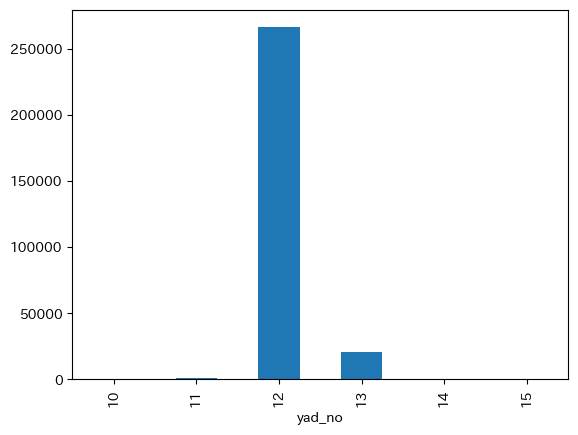

In [49]:
train_session_yad_df.groupby("session_id")[
    "yad_no"
].nunique().value_counts().sort_index().plot(kind="bar")

### „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å∏„ÅÆÂæåÂá¶ÁêÜ: „É≠„Ç∞„ÅÆ‰∏ÄÁï™ÊúÄÂæå„ÅÆÂÆø„ÅÆÂâäÈô§

„ÉÜ„Çπ„ÉàÁî®„Éá„Éº„Çø„ÅØÊúÄÁµÇÁöÑ„Å´„Äå„Åì„ÅÆÂÆø„Å´Ê≥ä„Åæ„Å£„Å¶„Çã?„Äç„Çí‰∫àÊ∏¨„Åô„ÇãÂØæË±°„Å´„Å™„ÇãÂÆø„ÇíÂÆöÁæ©„Åô„Çã„Åì„Å®„Å´„Å™„Çä„Åæ„Åô„ÄÇ‰ªäÂõû„ÅÆ„Éá„Éº„Çø„ÅØ„Äå„É≠„Ç∞„Éá„Éº„Çø„ÅÆ‰∏ÄÁï™ÊúÄÂæå„ÅÆÂÆø„ÅØÂøÖ„ÅöÊ≠£Ëß£„É©„Éô„É´„Åß„ÅØ„Å™„ÅÑ„Äç„Å®„ÅÑ„ÅÜÂà∂Á¥ÑÊù°‰ª∂„Åå„ÅÇ„Çã„ÅÆ„Åß„ÄÅ„Çª„ÉÉ„Ç∑„Éß„É≥„ÅÆÊúÄÂæå„ÅÆÂÆø„ÅØÂèñ„ÇäÂéª„ÇãÂá¶ÁêÜ„ÇíË°å„Å£„Å¶„Åä„Åç„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [50]:
def remove_last_yad_id(session_yad_df):
    # „Çª„ÉÉ„Ç∑„Éß„É≥‰∏≠‰∏ÄÁï™ÊúÄÂæå„ÅÆÂÆø„ÅÆÁµÑ„Çí‰ΩúÊàê
    last_yad_df = whole_log_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]

    # ÊúÄÂæå„Åß„ÅÇ„Çã„Åì„Å®„Åå„Çè„Åã„Çã„Çà„ÅÜ„Å´„É©„Éô„É´ is_last „Çí‰ªò‰∏é
    last_yad_df["is_last"] = 1

    # ÂºïÊï∞„ÅÆ session - yad „ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Å®„Éû„Éº„Ç∏„Åó„Å¶
    merged = session_yad_df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")

    # is_last **„Åß„ÅØ„Å™„ÅÑ** (i.e. is_last is null) „Éá„Éº„Çø„ÅÆ„Åø„Å´Áµû„Çã
    idx_use = merged["is_last"].isnull()
    out_df = session_yad_df[idx_use].reset_index(drop=True)

    return out_df


test_session_yad_df = remove_last_yad_id(test_session_yad_df)

<Axes: xlabel='yad_no'>

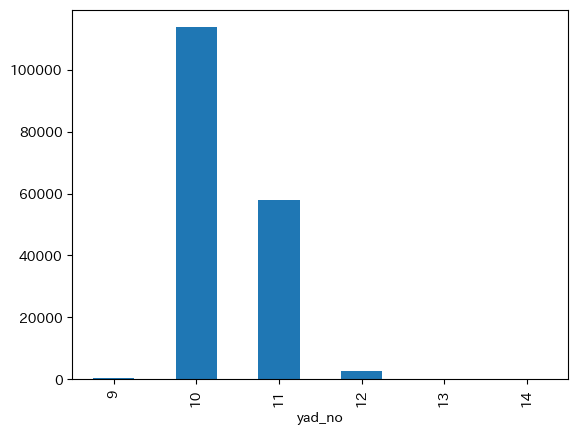

In [51]:
test_session_yad_df.groupby("session_id")[
    "yad_no"
].nunique().value_counts().sort_index().plot(kind="bar")

## ÁâπÂæ¥Èáè„ÅÆ‰ΩúÊàê

Â≠¶Áøí„Å´‰Ωø„ÅÜÂÆø„ÅåÊ±∫„Åæ„Çä„Åæ„Åó„Åü! Ê¨°„ÅØÊ©üÊ¢∞Â≠¶Áøí„É¢„Éá„É´„Åå„Åù„ÅÆ„Éë„Çø„Éº„É≥„É≥„ÇíË™çË≠ò„Åß„Åç„Çã„Çà„ÅÜ„Å™Â±ûÊÄßÊÉÖÂ†±„Çí„Éá„Éº„Çø„Å´‰ªò‰∏é„Åó„Å¶„ÅÑ„Åç„Åæ„Åô„ÄÇ„Åì„ÅÆ„Çà„ÅÜ„Å´„Éá„Éº„Çø„Å´Á¥ê„Å•„ÅèÂ±ûÊÄß„ÅÆ„Åì„Å®„ÇíÁâπÂæ¥Èáè„Å®Âëº„Å≥„Åæ„Åô„ÄÇÁâπÂæ¥Èáè„Çí„Å©„ÅÆ„Çà„ÅÜ„Å´‰Ωú„Çã„Åã?„ÅØÊ©üÊ¢∞Â≠¶Áøí„ÅÆÊÄßËÉΩ„ÇíÊ±∫„ÇÅ„Çã‰∏ä„ÅßÂ§ßÂ§âÈáçË¶Å„Åß„Åô„ÄÇ

‰ªäÂõû„ÅØ `session_id` / `yad_no` „ÅÆ2Âàó„Åå„ÅÇ„Çä„Åæ„Åô„Åã„Çâ„Åì„Çå„Çâ„ÅÆÂàó„ÅÆÊÉÖÂ†±„Çí‰Ωø„ÅÜ„Åì„Å®„Åå„Åß„Åç„Åæ„Åô„ÄÇ

### „Çª„ÉÉ„Ç∑„Éß„É≥„ÅÆÊÉÖÂ†±

„Çª„ÉÉ„Ç∑„Éß„É≥„Å´Á¥ê„Å•„Åè„Çà„ÅÜ„Å™ÊÉÖÂ†±„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„Åå„ÄÅ„Çª„ÉÉ„Ç∑„Éß„É≥„Åå„Å©„ÅÆ„Åê„Çâ„ÅÑ„ÅÆÈï∑„Åï„Å†„Å£„Åü„Åã?„ÅÆÊÉÖÂ†±„ÅØ‰Ωø„Åà„Åù„ÅÜ„Åß„Åô„ÄÇ

In [52]:
session_length = whole_log_df.groupby("session_id")["seq_no"].max()

In [53]:
def create_session_length_feature(input_df: pd.DataFrame):
    session_length = (
        whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")
    )

    out_df = pd.merge(
        input_df["session_id"], session_length, on="session_id", how="left"
    ).drop(columns=["session_id"])
    return out_df

In [54]:
create_session_length_feature(train_session_yad_df)

session_length
0                     0
1                     0
2                     0
3                     0
4                     0
...                 ...
3484697               1
3484698               1
3484699               1
3484700               1
3484701               1

[3484702 rows x 1 columns]

In [55]:
# 2ÂõûÂêå„ÅòÈñ¢Êï∞„Çí‰Ωø„Å£„Å¶ÁâπÂæ¥„Çí‰Ωú„Å£„Åü„Å®„ÅçÂêå‰∏Ä„ÅÆ„Éá„Éº„Çø„Åå„Åß„Åç„Çã„Åã? „Çí„ÉÜ„Çπ„Éà„Åó„Å¶„Åä„Åè„Å®Â∞ë„ÅóÂÆâÂøÉ„Åß„Åô
assert create_session_length_feature(train_session_yad_df).equals(
    create_session_length_feature(train_session_yad_df)
)

### ÂÆø„ÅÆÊÉÖÂ†±

Ê¨°„Å´ËÄÉ„Åà„Çâ„Çå„Çã„ÅÆ„ÅØÂÆø„ÅÆÊÉÖÂ†±„Åß„Åô„ÄÇÂÆø„Å´„ÅØ„Éû„Çπ„Çø„ÉºÊÉÖÂ†±„Åå‰ªòÈöè„Åó„Å¶„ÅÑ„Åæ„Åô„ÅÆ„Åß„Åì„Çå„Çí‰Ωø„ÅÜ„Åì„Å®„Åå„Åß„Åç„Åæ„Åô„ÄÇ

In [56]:
yado_df.dtypes

yad_no                 int64
yad_type               int64
total_room_cnt       float64
wireless_lan_flg     float64
onsen_flg              int64
kd_stn_5min          float64
kd_bch_5min          float64
kd_slp_5min          float64
kd_conv_walk_5min    float64
wid_cd                object
ken_cd                object
lrg_cd                object
sml_cd                object
dtype: object

In [57]:
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]

    # key „Å®„Å™„Çã `yad_no` „Çí‰ªò‰∏é„Åô„Çã„ÅÆ„Çí„ÅäÂøò„Çå„Å™„Åè.
    out_df = pd.merge(
        input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left"
    ).drop(columns=["yad_no"])
    return out_df

In [58]:
create_yado_numaric_feature(train_session_yad_df)

yad_type  total_room_cnt  wireless_lan_flg  onsen_flg  kd_stn_5min  \
0               0           134.0               1.0          0          NaN   
1               0             7.0               1.0          1          NaN   
2               0           113.0               1.0          0          NaN   
3               0            10.0               1.0          1          NaN   
4               0            39.0               NaN          0          NaN   
...           ...             ...               ...        ...          ...   
3484697         0            56.0               NaN          1          NaN   
3484698         0           150.0               1.0          0          1.0   
3484699         0           100.0               1.0          0          1.0   
3484700         0            70.0               1.0          0          NaN   
3484701         0           161.0               1.0          0          1.0   

         kd_bch_5min  kd_slp_5min  kd_conv_walk_5min  
0                NaN          NaN                1.0  
1                NaN          NaN                NaN  
2                NaN          NaN                NaN  
3                NaN          NaN                1.0  
4                NaN          NaN                1.0  
...              ...          ...                ...  
3484697          NaN          NaN                1.0  
3484698          NaN          NaN                1.0  
3484699          NaN          NaN                1.0  
3484700          NaN          NaN                1.0  
3484701          NaN          NaN                1.0  

[3484702 rows x 8 columns]

In [59]:
assert create_yado_numaric_feature(train_session_yad_df).equals(
    create_yado_numaric_feature(train_session_yad_df)
)

ÂÆø„Å´„ÅØ‰ªñ„Å´„ÇÇ wid_cd „Å™„Å©„Ç´„ÉÜ„Ç¥„É™Êâ±„ÅÑ„ÅÆÂàó„ÇÇ„ÅÇ„Çä„Åæ„Åô„ÄÇ„Åì„Çå„Çâ„ÅØÁõ¥Êé•„ÅØ„É¢„Éá„É´„Å´„ÅÑ„Çå„Çã„Åì„Å®„ÅØ„Åß„Åç„Å™„ÅÑ„Åü„ÇÅ„ÄÅÊï∞ÂÄ§„Å´Â§âÊèõ„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ„Çà„Åè„ÅÇ„ÇãÊñπÊ≥ï„Å®„Åó„Å¶ LabelEncoding „ÇÑ OneHotEncoding, CountEncoding „Å™„Å©„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ‰ªäÂõû„ÅØ LabelEncoding „Çí‰Ωø„Å£„Å¶Ë¶ã„Åæ„Åô„ÄÇ

In [60]:
# LabelEncoding „ÅØ scikit-learn „Å´Â§âÊèõ„É≠„Ç∏„ÉÉ„ÇØ„ÅåÁî®ÊÑè„Åï„Çå„Å¶„ÅÑ„Åæ„Åô„ÅÆ„Åß„Åù„Çå„ÇíÂà©Áî®„Åô„Çã„ÅÆ„Åå‰æøÂà©„Åß„Åô„ÄÇ
from sklearn.preprocessing import LabelEncoder

# ‰Ωø„ÅÑÊñπ„ÅØ„Ç∑„É≥„Éó„É´„Åß, LabelEncoder „ÇíÂÆöÁæ©„Åó„Åü„ÅÇ„Å® fit_trainsform „Åß‰∏é„Åà„Çâ„Çå„ÅüÈÖçÂàó„ÇíÊï∞ÂÄ§ Label „Å´Â§âÊèõ„Åó„Åæ„Åô„ÄÇ
le = LabelEncoder()

wid_cd_label = le.fit_transform(yado_df["wid_cd"])
sml_cd_label = le.fit_transform(yado_df["sml_cd"])

In [61]:
def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame(
        {"yad_no": yado_df["yad_no"], "wid_cd_label": wid_cd_label}
    )

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(
        columns=["yad_no"]
    )
    return out_df


def create_yad_sml_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame(
        {"yad_no": yado_df["yad_no"], "sml_cd_label": sml_cd_label}
    )

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(
        columns=["yad_no"]
    )
    return out_df

In [62]:
create_yad_wid_cd_feature(train_session_yad_df)

wid_cd_label
0                   4
1                   3
2                   9
3                  10
4                   9
...               ...
3484697            11
3484698            10
3484699             9
3484700            10
3484701             3

[3484702 rows x 1 columns]

In [63]:
assert create_yad_wid_cd_feature(train_session_yad_df).equals(
    create_yad_wid_cd_feature(train_session_yad_df)
)

### ÁâπÂæ¥Èáè„ÅÆ„Éû„Éº„Ç∏

‰∏äË®ò„ÅÆÁâπÂæ¥Èáè‰ΩúÊàêÈñ¢Êï∞„ÇíÈÄ£Á∂öÁöÑ„Å´Âëº„Å≥Âá∫„Åó & ÁµêÂêà„Åó„Å¶„ÄÅÂ≠¶Áøí„Å´‰Ωø„ÅÜÁâπÂæ¥ÈáèÂÖ®‰Ωì„Å´„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [64]:
# „ÅÑ„Åæ„Åæ„Åß„ÅÆÈñ¢Êï∞„Çí„Åô„Åπ„Å¶„Åå„Å£„Å°„ÇÉ„Çì„Åì„Åó„Å¶ÁâπÂæ¥Èáè„Çí‰ΩúÊàê„Åô„ÇãÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„Åó„Çá„ÅÜ!


def create_feature(input_df):
    # functions „Å´ÁâπÂæ¥Èáè‰ΩúÊàêÈñ¢Êï∞„ÇíÈÖçÂàó„ÅßÂÆöÁæ©„Åó„Åæ„Åó„Åü.
    # „Å©„ÅÆÈñ¢Êï∞„ÇÇÂêå„Åò input / output „ÅÆ„Ç§„É≥„Çø„Éº„Éï„Çß„Ç§„Çπ„Å™„ÅÆ„Åß for „ÅßÂõû„Åõ„Å¶Â¨â„Åó„ÅÑ„Åß„Åô„Å≠ ;)
    functions = [
        # create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
        create_yad_sml_cd_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [65]:
# ÂÆüË°å„Åó„Å¶ train / test Áî®„ÅÆÁâπÂæ¥Èáè„Çí‰Ωú„Çä„Åæ„Åô.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_yado_numaric_feature 0.187[s]
- create create_yad_wid_cd_feature 0.122[s]
- create create_yad_sml_cd_feature 0.120[s]
train... 0.499[s]
- create create_yado_numaric_feature 0.103[s]
- create create_yad_wid_cd_feature 0.067[s]
- create create_yad_sml_cd_feature 0.063[s]
test... 0.273[s]


In [82]:
test_feat_df

yad_type  total_room_cnt  wireless_lan_flg  onsen_flg  kd_stn_5min  \
0               0           134.0               1.0          0          NaN   
1               0             7.0               1.0          1          NaN   
2               0           205.0               1.0          0          NaN   
3               0            10.0               1.0          1          NaN   
4               0           108.0               1.0          0          NaN   
...           ...             ...               ...        ...          ...   
1809595         0            12.0               NaN          1          NaN   
1809596         0            84.0               1.0          0          NaN   
1809597         0            45.0               1.0          0          NaN   
1809598         0            49.0               1.0          1          NaN   
1809599         0            92.0               1.0          0          NaN   

         kd_bch_5min  kd_slp_5min  kd_conv_walk_5min  wid_cd_label  \
0                NaN          NaN                1.0             4   
1                NaN          NaN                NaN             3   
2                NaN          NaN                1.0             3   
3                NaN          NaN                1.0            10   
4                NaN          NaN                NaN             1   
...              ...          ...                ...           ...   
1809595          NaN          NaN                NaN             7   
1809596          NaN          NaN                1.0             9   
1809597          NaN          NaN                1.0            10   
1809598          NaN          NaN                1.0             5   
1809599          NaN          NaN                1.0             7   

         sml_cd_label  
0                 344  
1                  11  
2                 298  
3                 522  
4                  38  
...               ...  
1809595           497  
1809596           123  
1809597           302  
1809598           424  
1809599           460  

[1809600 rows x 10 columns]

## „É¢„Éá„É´„ÅÆÂ≠¶Áøí

ÁâπÂæ¥Èáè„Çí‰ΩúÊàê„Åß„Åç„Åü„ÅÆ„ÅßÊ¨°„Å´„É¢„Éá„É´„ÅÆÂ≠¶Áøí„ÇíË°å„Å£„Å¶„ÅÑ„Åç„Åæ„Åô„ÄÇ„Åì„ÅÆÊôÇÂ§ß‰∫ã„Å´„Å™„Çã„ÅÆ„Åå‰∫§Â∑ÆÊ§úË®º (Cross Validation) „Å®„ÅÑ„ÅÜËÄÉ„ÅàÊñπ„Åß„Åô„ÄÇ

### Cross Validation „Å®„ÅØ

Cross Validation „Å®„ÅØÂ≠¶ÁøíÁî®„ÅÆ„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÇíË§áÊï∞„Å´ÂàÜÂâ≤„Åó„Å¶„Åù„Çå„Åû„Çå„ÅÆÂàÜÂâ≤„ÅßÂ≠¶Áøí„ÉªÊ§úË®º„ÅÆ„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí‰Ωú„Çä„ÄÅ„É¢„Éá„É´„ÅÆÊÄßËÉΩ„ÇíË¶ãÁ©ç„ÇÇ„ÇãÊû†ÁµÑ„Åø„ÅÆ„Åì„Å®„Åß„Åô„ÄÇ

### „Å™„Çì„Åß Cross Validation „Åô„Çã„ÅÆ?

„Å™„Åú„Çè„Åñ„Çè„ÅñÂàÜÂâ≤„Åô„Çã„ÅÆ? („Åù„ÅÆ„Åæ„ÅæÂÖ®ÈÉ®Â≠¶Áøí„Åß‰Ωø„Å£„Å°„ÇÉ„Åà„Å∞„ÅÑ„ÅÑ„Åò„ÇÉ„Å™„ÅÑ?) „Å®ÊÄù„Çè„Çå„Çã„ÅÆ„ÅåÊôÆÈÄö„Å†„Å®ÊÄù„ÅÑ„Åæ„Åô„ÄÇ„Å™„ÅúÂàÜÂâ≤„Åô„Çã„Åã„Å®„ÅÑ„ÅÜ„Å®Â≠¶Áøí„Éá„Éº„Çø„ÅÆ‰∏≠„Åß‰ªä„ÅÆÊû†ÁµÑ„Åø„ÅÆÊÄßËÉΩ(Êû†ÁµÑ„Åø„Å®Ë®Ä„Å£„Å¶„ÅÑ„Çã„ÅÆ„ÅØÁâπÂæ¥Èáè„Éª„É¢„Éá„É´„ÅÆÊßãÊàê„ÇÇ„Çç„ÇÇ„ÇçÂÖ®ÈÉ®„ÅåÂê´„Åæ„Çå„Çã„Åü„ÇÅ„Åß„Åô)„ÇíË©ï‰æ°„Åó„Åü„ÅÑ„Åã„Çâ„Åß„Åô„ÄÇÊâãÂÖÉ„ÅßË©ï‰æ°„Åå„Åß„Åç„Å™„ÅÑ„Å®LB„Å´Âá∫„Åó„Å¶„Åø„Å¶‰∏ÄÂñú‰∏ÄÊÜÇ„Åô„Çã„Åó„Åã„Å™„Åè„Å™„Çä„ÄÅÁµêÊûúpublicLB„Å´„Ç™„Éº„Éê„Éº„Éï„Ç£„ÉÉ„Éà„Åó„Å¶„Åó„Åæ„ÅÜ„ÅÆ„Åß„Çà„Çç„Åó„Åè„Å™„ÅÑ„Åß„Åô„ÄÇ

‰ªï‰∫ãÁöÑ„Å™Ë¶≥ÁÇπ„ÅßË®Ä„Å£„Å¶„ÇÇLB„Å´Âá∫„Åô„Å®„ÅÑ„ÅÜ„ÅÆ„ÅØ„Éá„Éó„É≠„Ç§(Êú¨Áï™„Å∏ÂèçÊò†„Åô„Çã„Åì„Å®)„Åß„Åô„Åã„Çâ„ÄÅÊú¨Áï™„Å´Âá∫„Åï„Å™„ÅÑ„Å®„É¢„Éá„É´„ÅÆËâØ„ÅóÊÇ™„Åó„Åå„Çè„Åã„Çâ„Å™„ÅÑ„ÅÆ„ÅØ„Çà„Çç„Åó„Åè„Å™„ÅÑ„Åß„Åô„Çà„Å≠?

* ‰∏ÄÁï™„Éä„Ç§„Éº„Éñ„Å™Êà¶Áï•„ÅØ Random „Å®Âëº„Å∞„Çå„Çã„ÇÇ„ÅÆ„Åß„Åô„ÄÇ„Åì„Çå„ÅØ‰Ωï„ÇÇËÄÉ„Åà„Åö„Å´„Å®„Å´„Åã„Åè„É©„É≥„ÉÄ„É†„Å´Â≠¶Áøí„Éá„Éº„Çø„ÇíÂàÜÂâ≤„Åó„Åæ„Åô„ÄÇ
* „Çø„Éº„Ç≤„ÉÉ„Éà„ÅÆÂàÜÂ∏É„ÅåÂêå„Åò„Å´„Å™„Çã„Çà„ÅÜ„Å´ÂàÜÂâ≤„Åô„Çã Stratified „Å®Âëº„Å∞„Çå„ÇãÊñπÊ≥ï„ÇÇ„ÅÇ„Çä„Åæ„Åô„ÄÇ
* „ÄåÂêÑÂàÜÂâ≤„ÅßÁâπÂÆö„ÅÆ„Ç∞„É´„Éº„Éó„ÅåÈáç„Å™„Çâ„Å™„ÅÑ„Çà„ÅÜ„Å´„Åô„Çã„ÄçGroup „ÇÇ„Çà„Åè‰Ωø„Çè„Çå„Åæ„Åô„ÄÇ

---

‰ªäÂõû„ÅØ train / test „Åß session „ÅåÂàÜ„Åë„Çâ„Çå„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÂä†Âë≥„Åó„Å¶ session_id „ÅÆ Group „ÅßÂàÜÂâ≤„Åô„ÇãÊñπÊ≥ï„ÇíÂà©Áî®„Åó„Åæ„Åô„ÄÇ

In [66]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_session_yad_df["session_id"].values)
cv = list(cv)  # split „ÅÆËøî„ÇäÂÄ§„ÅØ generator „Å™„ÅÆ„Åß list Âåñ„Åó„Å¶‰ΩïÂ∫¶„ÇÇ iterate „Åß„Åç„Çã„Çà„ÅÜ„Å´„Åó„Å¶„Åä„Åè

### LightGBM „Å´„Çà„Çã CrossValidation „ÇíÁî®„ÅÑ„ÅüÂ≠¶Áøí

‰ªäÂõû„ÅØ‰Ωø„ÅÜÊ©üÊ¢∞Â≠¶Áøí„É¢„Éá„É´„Å®„Åó„Å¶ lightGBM „Çí‰Ωø„ÅÑ„Åæ„Åô„ÄÇlightGBM „ÅØ‰ª•‰∏ã„ÅÆ„Çà„ÅÜ„Å™ËâØ„ÅÑÊÄßË≥™„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ

* GBDT „Å®Âëº„Å∞„Çå„Çã„Ç¢„É´„Ç¥„É™„Ç∫„É†„ÅÆ‰∏ÄÁ®Æ„Åß„ÉÜ„Éº„Éñ„É´„Éá„Éº„Çø„ÅßÊÄßËÉΩ„ÅåÈ´ò„ÅÑ„Åì„Å®„ÅåÁü•„Çâ„Çå„Å¶„ÅÑ„Çã
* Ê¨†ÊêçÂÄ§„ÅåÂ≠òÂú®„Åó„Å¶„ÅÑ„ÇãÂ†¥Âêà„Å´„ÇÇËá™ÁÑ∂„Å´Âèñ„ÇäÊâ±„Åà„Çã„Åü„ÇÅÁâπ„Å´Âá¶ÁêÜ„ÅåÂøÖË¶Å„Å™„ÅÑ
* ÁâπÂæ¥Èáè„ÅÆ„Çπ„Ç±„Éº„É´„ÇíÊèÉ„Åà„Åü„Çä„Åó„Å™„Åè„Å¶„Çà„ÅÑ
* ÁâπÂæ¥ÈáçË¶ÅÂ∫¶„Çí„Åï„Å£„Å®Âá∫„Åô„Åì„Å®„Åå„Åß„Åç„Çã
* CPU Áí∞Â¢É„Åß„ÇÇÈ´òÈÄü„Å´Â≠¶Áøí„ÉªÊé®Ë´ñ„ÅåË°å„Åà„Çã

u++ „Åï„Çì„ÅÆ [„ÄåÂàùÊâãLightGBM„Äç„Çí„Åô„Çã7„Å§„ÅÆÁêÜÁî±](https://upura.hatenablog.com/entry/2019/10/29/184617) „Å™„Å©„ÅåÂèÇËÄÉ„Å´„Å™„Çä„Åæ„Åô„ÄÇ

> ref: https://lightgbm.readthedocs.io/en/stable/

In [67]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_squared_log_error,
    median_absolute_error,
    explained_variance_score,
    cohen_kappa_score,
    average_precision_score,
    precision_score,
    recall_score,
)


def binary_metrics(
    y_true: np.ndarray, predict_probability: np.ndarray, threshold=0.5
) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [accuracy_score, f1_score, precision_score, recall_score]

    prob_functions = [roc_auc_score, log_loss, average_precision_score]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores


def fit_lgbm(X, y, cv, params: dict = None):
    """lightGBM „Çí CrossValidation „ÅÆÊû†ÁµÑ„Åø„ÅßÂ≠¶Áøí„ÇíË°å„Å™„ÅÜ function"""

    # „Éë„É©„É°„Éº„Çø„Åå„Å™„ÅÑ„Å®„Åç„ÅØ„ÄÅÁ©∫„ÅÆ dict „ÅßÁΩÆ„ÅçÊèõ„Åà„Çã
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data „ÅÆ target „Å®Âêå„Åò„Å†„Åë„ÅÆ„Çº„É≠ÈÖçÂàó„ÇíÁî®ÊÑè
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        print(f"-- start fold {i}")
        # „Åì„ÅÆÈÉ®ÂàÜ„Åå‰∫§Â∑ÆÊ§úË®º„ÅÆ„Å®„Åì„Çç„Åß„Åô„ÄÇ„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí cv instance „Å´„Çà„Å£„Å¶ÂàÜÂâ≤„Åó„Åæ„Åô
        # training data „Çí trian/valid „Å´ÂàÜÂâ≤
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, verbose=0)

        with Timer(prefix="fit fold={} ".format(i)):
            # cv ÂÜÖ„Åß train „Å´ÂÆöÁæ©„Åï„Çå„Åü x_train „ÅßÂ≠¶Áøí„Åô„Çã
            clf.fit(
                x_train,
                y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=100, verbose=False),
                    lgbm.log_evaluation(
                        period=100,
                    ),
                ],
            )

        # cv ÂÜÖ„Åß validation data „Å®„Åï„Çå„Åü x_valid „Åß‰∫àÊ∏¨„Çí„Åó„Å¶ oof_pred „Å´‰øùÂ≠ò„Åó„Å¶„ÅÑ„Åè
        # oof_pred „ÅØÂÖ®ÈÉ®Â≠¶Áøí„Å´‰Ωø„Çè„Å™„Åã„Å£„Åü„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨ÁµêÊûú„Å´„Å™„Çã ‚Üí „É¢„Éá„É´„ÅÆ‰∫àÊ∏¨ÊÄßËÉΩ„ÇíË¶ã„ÇãÊåáÊ®ô„Å®„Åó„Å¶Âà©Áî®„Åß„Åç„Çã
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)
        print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

In [68]:
params = {
    # ÁõÆÁöÑÈñ¢Êï∞. „Åì„Çå„ÅÆÊÑèÂë≥„ÅßÊúÄÂ∞è„Å®„Å™„Çã„Çà„ÅÜ„Å™„Éë„É©„É°„Éº„Çø„ÇíÊé¢„Åó„Åæ„Åô.
    "objective": "binary",
    # Êú®„ÅÆÊúÄÂ§ßÊï∞
    "n_estimators": 10000,
    # Â≠¶ÁøíÁéá. Â∞è„Åï„ÅÑ„Åª„Å©„Å™„ÇÅ„Çâ„Åã„Å™Ê±∫ÂÆöÂ¢ÉÁïå„Åå‰Ωú„Çâ„Çå„Å¶ÊÄßËÉΩÂêë‰∏ä„Å´Áπã„Åå„ÇãÂ†¥Âêà„ÅåÂ§ö„ÅÑ„Åß„Åô„ÄÅ
    # „Åå„Åù„Çå„Å†„ÅëÊú®„Çí‰Ωú„Çã„Åü„ÇÅÂ≠¶Áøí„Å´ÊôÇÈñì„Åå„Åã„Åã„Çä„Åæ„Åô
    # ‰ªäÂõûË®≠ÂÆö„Åó„Å¶„ÅÑ„Çã 0.3 „ÅØÊØîËºÉÁöÑÂ§ß„Åç„ÇÅ„ÅÆË®≠ÂÆö„Åß„Åô
    "learning_rate": 0.3,
    # ÁâπÂæ¥ÈáçË¶ÅÂ∫¶Ë®àÁÆó„ÅÆ„É≠„Ç∏„ÉÉ„ÇØ(ÂæåËø∞)
    "importance_type": "gain",
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

-- start fold 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255611
[200]	valid_0's binary_logloss: 0.253232
[300]	valid_0's binary_logloss: 0.251687
[400]	valid_0's binary_logloss: 0.250727
[500]	valid_0's binary_logloss: 0.250035
[600]	valid_0's binary_logloss: 0.249485
[700]	valid_0's binary_logloss: 0.249106
[800]	valid_0's binary_logloss: 0.248804
[900]	valid_0's binary_logloss: 0.248579
[1000]	valid_0's binary_logloss: 0.248378
[1100]	valid_0's binary_logloss: 0.248244
[1200]	valid_0's binary_logloss: 0.24816
[1300]	valid_0's binary_logloss: 0.248077
[1400]	valid_0's binary_logloss: 0.248063
[1500]	valid_0's binary_logloss: 0.248028
[1600]	valid_0's binary_logloss: 0.248027
fit fold=0  40.697[s]


/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - fold1 - {'accuracy_score': 0.917152962614878, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7722626686760208, 'log_loss': 0.2480209951494587, 'average_precision_score': 0.21561874894906727}
-- start fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255902
[200]	valid_0's binary_logloss: 0.253404
[300]	valid_0's binary_logloss: 0.251892
[400]	valid_0's binary_logloss: 0.250991
[500]	valid_0's binary_logloss: 0.250312
[600]	valid_0's binary_logloss: 0.249766
[700]	valid_0's binary_logloss: 0.249365
[800]	valid_0's binary_logloss: 0.249119
[900]	valid_0's binary_logloss: 0.248885
[1000]	valid_0's binary_logloss: 0.248733
[1100]	valid_0's binary_logloss: 0.248628
[1200]	valid_0's binary_logloss: 0.248547
[1300]	valid_0's binary_logloss:

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - fold2 - {'accuracy_score': 0.9171527164984324, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7706754640828075, 'log_loss': 0.24843463009829841, 'average_precision_score': 0.2149622403404124}
-- start fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255661
[200]	valid_0's binary_logloss: 0.253072
[300]	valid_0's binary_logloss: 0.251629
[400]	valid_0's binary_logloss: 0.250681
[500]	valid_0's binary_logloss: 0.249983
[600]	valid_0's binary_logloss: 0.249413
[700]	valid_0's binary_logloss: 0.249006
[800]	valid_0's binary_logloss: 0.248694
[900]	valid_0's binary_logloss: 0.248467
[1000]	valid_0's binary_logloss: 0.248284
[1100]	valid_0's binary_logloss: 0.248184
[1200]	valid_0's binary_logloss: 0.248079
[1300]	valid_0's binary_logloss

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - fold3 - {'accuracy_score': 0.9171525976262082, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7724873871070295, 'log_loss': 0.24793372064824074, 'average_precision_score': 0.2155609173754435}
-- start fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255638
[200]	valid_0's binary_logloss: 0.25339
[300]	valid_0's binary_logloss: 0.251843
[400]	valid_0's binary_logloss: 0.250869
[500]	valid_0's binary_logloss: 0.250095
[600]	valid_0's binary_logloss: 0.249589
[700]	valid_0's binary_logloss: 0.249231
[800]	valid_0's binary_logloss: 0.249002
[900]	valid_0's binary_logloss: 0.248769
[1000]	valid_0's binary_logloss: 0.24862
[1100]	valid_0's binary_logloss: 0.248524
[1200]	valid_0's binary_logloss: 0.24844
[1300]	valid_0's binary_logloss: 0

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - fold4 - {'accuracy_score': 0.9171525976262082, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7714372555599531, 'log_loss': 0.24832117999084777, 'average_precision_score': 0.21507970351049488}
-- start fold 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255421
[200]	valid_0's binary_logloss: 0.252958
[300]	valid_0's binary_logloss: 0.251474
[400]	valid_0's binary_logloss: 0.250524
[500]	valid_0's binary_logloss: 0.249896
[600]	valid_0's binary_logloss: 0.249445
[700]	valid_0's binary_logloss: 0.24903
[800]	valid_0's binary_logloss: 0.248748
[900]	valid_0's binary_logloss: 0.248548
[1000]	valid_0's binary_logloss: 0.248395
[1100]	valid_0's binary_logloss: 0.248267
[1200]	valid_0's binary_logloss: 0.248168
[1300]	valid_0's binary_logloss

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - fold5 - {'accuracy_score': 0.9171528437413012, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7725664429493282, 'log_loss': 0.2480261083176298, 'average_precision_score': 0.21501977313982504}


/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FINISHI: Whole Score: {'accuracy_score': 0.9171527436205449, 'f1_score': 0.0, 'precision_score': 0.0, 'recall_score': 0.0, 'roc_auc_score': 0.7718798944830354, 'log_loss': 0.24814732768960635, 'average_precision_score': 0.21521561758076424}


## ÁµêÊûú„ÇíËß£Èáà„Åô„Çã

„É¢„Éá„É´„Åå„Åß„Åç„Åü! Ê¨°„ÅØ‰∫àÊ∏¨„Å†! „ÅÆÂâç„Å´‚Ä¶ ‰∏ÄÂ∫¶‰∫àÊ∏¨ÁµêÊûú„ÅÆË¶ãÁ©ç„ÇÇ„Çä„ÇíË°å„ÅÑ„Åæ„Åó„Çá„ÅÜ„ÄÇ

### ÊâãÂÖÉ„Åß„Çπ„Ç≥„Ç¢„ÇíË¶ãÁ©ç„ÇÇ„Çã

‰∫àÊ∏¨ÊôÇ„Å´„ÅØ 5 Fold „Å´ÂàÜ„Åë„Å¶„É¢„Éá„É´„Çí‰Ωú„Çä„Åæ„Åó„Åü„ÅÆ„Åß `oof` „Å´Âê´„Åæ„Çå„Çã„Éá„Éº„Çø„ÅØÂÆåÂÖ®„Å´Ê≠£Ëß£ÊÉÖÂ†±„ÇíÁü•„Çâ„Å™„ÅÑÁä∂ÊÖã„Åß‰∫àÊ∏¨„Åï„Çå„ÅüÁ¢∫Áéá„Å´„Å™„Å£„Å¶„ÅÑ„Åæ„Åô„ÄÇ„Åì„Çå„Çí‰Ωø„Å£„Å¶‰ªäÂõû„ÅÆÊåáÊ®ô MAP@10 „ÅÆ„Çπ„Ç≥„Ç¢„ÇíË¶ãÁ©ç„ÇÇ„Å£„Å¶Ë¶ã„Åæ„Åó„Çá„ÅÜ„ÄÇ

„Åæ„Åö„ÅØ‰∫àÊ∏¨Á¢∫Áéá„Å®„ÇÇ„Å®„ÅÆ„Çª„ÉÉ„Ç∑„Éß„É≥„ÉªÂÆøÊÉÖÂ†±„Åã„Çâ„ÄÅ„Çª„ÉÉ„Ç∑„Éß„É≥„Åî„Å®„Å´‰∫àÊ∏¨Á¢∫Áéá„ÅÆÈ´ò„ÅÑÂÆøNo„Çí10‰ª∂ÂèñÂæó„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇ„Åì„Çå„ÅØ„ÅÇ„Å®„Åß„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶„ÇÇÂêå„Åò„Åì„Å®„Çí„Åó„Åæ„Åô„ÅÆ„Åß„ÄÅÈñ¢Êï∞„Å´„Åó„Å¶„Åä„Åè„Å®‰æøÂà©„Åß„Åô„Å≠„ÄÇ

In [69]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat(
        [session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")],
        axis=1,
    )

    # „Çª„ÉÉ„Ç∑„Éß„É≥„Åî„Å®„Å´‰∫àÊ∏¨Á¢∫Áéá„ÅÆÈ´ò„ÅÑÈ†Ü„Å´ yad_no „ÅÆÈÖçÂàó„Çí‰ΩúÊàê
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]

    out_df = out_df.fillna(0).astype(int)

    return out_df

In [70]:
oof_label_df = create_top_10_yad_predict(
    predict=oof, session_yad_df=train_session_yad_df
)

oof_label_df

0      1      2      3      4     5  \
session_id                                                                  
000007603d533d30453cc45d0f3d119f   4523  11025   4844   3740    822  8050   
0000ca043ed437a1472c9d1d154eb49b  13682  11705   8253   7502  13535   713   
0000d4835cf113316fe447e2f80ba1c8  11192  13265   5495   8304   6694  4822   
0000fcda1ae1b2f431e55a7075d1f500   1652  12320   5999   9270   1276  8186   
000104bdffaaad1a1e0a9ebacf585f33  11512    898     96  13125   6100  7787   
...                                 ...    ...    ...    ...    ...   ...   
ffff2262d38abdeb247ebd591835dcc9   8140   2259  12464   2131   1502  3066   
ffff2360540745117193ecadcdc06538    846  10832   6721   6215    963  2121   
ffff7fb4617164b2604aaf51c40bf82d   7183  13719   6257   1367   7577  1680   
ffffcd5bc19d62cad5a3815c87818d83  12230   9045  10619    290   1728  9391   
fffffa7baf370083ebcdd98f26a7e31a  11683  11822   5677   7633  10750  2439   

                                      6      7      8      9  
session_id                                                    
000007603d533d30453cc45d0f3d119f   2395   6461   4101   1272  
0000ca043ed437a1472c9d1d154eb49b   3866   1210  10016   2029  
0000d4835cf113316fe447e2f80ba1c8   6691   5559  12567   4863  
0000fcda1ae1b2f431e55a7075d1f500   8475  12439  12813   3305  
000104bdffaaad1a1e0a9ebacf585f33  10817  11067   8205   2691  
...                                 ...    ...    ...    ...  
ffff2262d38abdeb247ebd591835dcc9   7306   3695  13697  12332  
ffff2360540745117193ecadcdc06538   4923   8666   7058   6884  
ffff7fb4617164b2604aaf51c40bf82d  12417   5196   1550    133  
ffffcd5bc19d62cad5a3815c87818d83   3869   5471   2290   2156  
fffffa7baf370083ebcdd98f26a7e31a  10314   2507   9689    936  

[288698 rows x 10 columns]

‰ªäÂõû„ÅÆË©ï‰æ°ÊåáÊ®ô„ÅØ MAP@10 „Åß„Åô„ÄÇË®àÁÆóÊñπÊ≥ï„ÅØ https://www.guruguru.science/competitions/22/discussions/a62aed5d-438d-46c7-8e44-85e5e5d41e64/ „ÅÆ @camaro „Åï„Çì„Ç≥„Éº„Éâ„ÇíÂºïÁî®„Åó„Åæ„Åó„Åü„ÄÇ

In [71]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [72]:
# „ÅÑ„Åæ‰ΩúÊàê„Åó„Åü session_id „Å®Âêå„Åò‰∏¶„Å≥„Åß train_label „Çí‰∏¶„Å≥Êõø„Åà
train_label = (
    train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [73]:
# MAPK (k=10) „Å®„Åó„Å¶Ë®àÁÆó
oof_score_mapk = mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)
oof_score_mapk

0.46528231649076496

Â≠¶ÁøíÊôÇ„ÅÆË¶ãÁ©ç„ÇÇ„Çä„Å®„Åó„Å¶ÊÄßËÉΩ„ÅØ `0.444` „Å®„Å™„Çä„Åæ„Åó„Åü„ÄÇ„Åì„Çå„ÅØ‰ªä„ÅÆLB„Å†„Å®„Åã„Å™„Çä2‰Ωç„ÇíÂºï„ÅçÈõ¢„Åó„Å¶1‰Ωç„Åß„Åô„Å≠„ÄÇ

#### note: Ë¶ãÁ©ç„ÇÇ„Çä„Å´Âê´„Åæ„Çå„Å¶„ÅÑ„Çã„Éê„Ç§„Ç¢„Çπ

Â≠¶ÁøíÊôÇ„Å´„ÅØÊ≠£Ëß£„ÅÆÂÆø„Çí„Çª„ÉÉ„Ç∑„Éß„É≥„Å´Âê´„ÇÅ„ÇãÂÆüË£Ö„Çí„Åó„Åü„ÅÆ„ÇíÊÄù„ÅÑÂá∫„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ„Åì„Çå„Å´„Çà„Å£„Å¶„ÄÅ„Åì„ÅÆÊÄßËÉΩË¶ãÁ©ç„ÇÇ„Çä„Å´„ÅØ„Äå‰∫àÊ∏¨„Åó„Å¶„ÅÑ„ÇãÂÆøNo„ÅÆ„Å™„Åã„Å´ÂøÖ„ÅöÊ≠£Ëß£„ÅÆÂÆøNo„ÅåÂê´„Åæ„Çå„Å¶„ÅÑ„Çã„Äç„Å®„ÅÑ„ÅÜÂâçÊèê„ÅåÂê´„Åæ„Çå„Çã„Åì„Å®„Å´„Å™„Å£„Å¶„ÅÑ„Åæ„Åô„ÄÇ

ÂÆüÈöõ„Å´„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Çí‰∫àÊ∏¨„Åô„ÇãÈöõ„Å´„ÅØ„Å©„Çå„Åå‰∫àÁ¥Ñ„Åï„Çå„Åü„Åã„Çè„Åã„Çâ„Å™„ÅÑÁä∂ÊÖã„ÅßÊé®Ë´ñ„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çã„Åü„ÇÅ„ÄÅ„Åì„ÅÆÊÄßËÉΩ„ÅØÈÅéÂâ∞„Å™Ë¶ãÁ©ç„ÇÇ„Çä„Å´„Å™„Å£„Å¶„ÅÑ„Çã„Å†„Çç„ÅÜ„Åì„Å®„Åå‰º∫„Åà„Åæ„Åô„ÄÇ„Ç´„Ç∏„É•„Ç¢„É´„Å´„ÅÑ„ÅÜ„Å®„ÄåÁµ∂ÂØæ„Å´„Åì„ÅÆÂÄôË£ú„ÅÆ‰∏≠„Å´Ê≠£Ëß£„Åå„ÅÇ„Çã„Åû!„Äç„Å®„ÅÑ„ÅÜÁä∂ÊÖã„ÅßË¶ãÁ©ç„ÇÇ„Å£„Å¶„ÅÑ„Çã„ÅÆ„Åß„Åô„Åå„ÄÅ„ÉÜ„Çπ„ÉàÊôÇ„Å´„ÅØ„Åù„ÅÆÁ¢∫Ë®º„ÅØ„Å™„Åè„Äå„ÇÇ„Åó„Åã„Åó„Åü„Çâ„Åì„ÅÆ‰∏≠„Å´„ÅØ‰∏Ä„Å§„ÇÇÊ≠£Ëß£„ÅØÁÑ°„ÅÑ„Åã„ÇÇ„Åó„Çå„Å™„ÅÑ„Äç„Å®„ÅÑ„ÅÜÁä∂ÊÖã„Åß‰∫àÊ∏¨„Åô„Çã„Åü„ÇÅ„ÄÅÊÄßËÉΩ„ÅåÈÅéÂâ∞„Å´Ë¶ãÁ©ç„ÇÇ„Çâ„Çå„Åü„ÅÑ„Çè„Å∞‰∏ãÈßÑ„ÅåÂ±•„Åã„Åï„Çå„Å¶„ÅÑ„ÇãÁä∂ÊÖã„Å´„Å™„Å£„Å¶„ÅÑ„Çã„ÄÅ„Å®„ÅÑ„ÅÜ„Åì„Å®„Åß„Åô„ÄÇ

#### FutureWork

* „Éê„Ç§„Ç¢„Çπ„ÇíÂèñ„ÇäÈô§„ÅÑ„Å¶Ë©ï‰æ°„Çí„Åô„ÇãÊñπÊ≥ï„ÅØÁÑ°„ÅÑ„Åß„Åó„Çá„ÅÜ„Åã?

### ‰∫àÊ∏¨„É¢„Éá„É´„ÅÆ‰∏≠Ë∫´„ÇíÁêÜËß£„Åô„Çã

LightGBM „Å™„Å©Êú®Á≥ª„ÅÆ„É¢„Éá„É´„Åß„ÅØ„Å©„ÅÆÁâπÂæ¥Èáè„ÅßÂàÜÂâ≤„ÇíË°å„Å£„Å¶„Å©„Çå„Å†„ÅëÁõÆÁöÑÂ§âÊï∞„ÇíË™¨Êòé„Åó„Å¶„ÅÑ„Çã„Åã„ÇíÁâπÂæ¥ÈáçË¶ÅÂ∫¶ (feature importance) „Å®„Åó„Å¶Âá∫Âäõ„Åô„Çã„Åì„Å®„Åå„Åß„Åç„Åæ„Åô„ÄÇ„Åì„Çå„ÇíË¶ã„Çã„Åì„Å®„Åß

* „Å©„ÅÆÁâπÂæ¥Èáè„ÅåÂ§ß‰∫ã„Å™„ÅÆ„Åã
* „Å©„ÅÆÁâπÂæ¥Èáè„ÅØ„ÅÇ„Åæ„ÇäÂ§ß‰∫ã„Åß„ÅØ„Å™„ÅÑ„Åã

„Å®„ÅÑ„Å£„ÅüÁâπÂæ¥Èáè„Å´Èñ¢„Åô„ÇãÊÉÖÂ†±„ÇíÂæó„Çã„Åì„Å®„Åå„Åß„Åç„Åæ„Åô„ÄÇ„Åì„Çå„Å´„Çà„Å£„Å¶„ÄÅ‰æã„Åà„Å∞ÈáçË¶Å„Å®„Å™„Å£„ÅüÁâπÂæ¥Èáè„Çí‰Ωø„ÅÜÂà•„ÅÆÁâπÂæ¥„ÇíËÄÉ„Åà„Åü„Çä„ÄÅÂèçÂØæ„Å´Â§ß‰∫ã„Åß„ÅØ„Å™„ÅÑÁâπÂæ¥„ÇíÂâä„Å£„Åü„Çä„Å®„ÅÑ„Å£„Åü„Ç§„É≥„Çµ„Ç§„Éà„ÇíÂæó„Çã„Åì„Å®„ÅåÂèØËÉΩ„Åß„Åô„ÄÇ„Åæ„Åü‰ΩïÊïÖ„Åì„ÅÆ‰∫àÊ∏¨„ÅåÂá∫„Å¶„Åè„Çã„Åã„ÅÆËß£Èáà„Çí„Åô„Çã‰∏ä„Åß„ÇÇÊúâÁî®„Åß„Åô„ÄÇ

> note: ‰ªäÂõûÂà©Áî®„Åó„Åü lightGBM „ÅØÂÜÖÈÉ®ÁöÑ„Å´ÁâπÂæ¥„ÅÆÂÄ§„Åß„ÅÆ IF „Çí„Åü„Åè„Åï„ÇìÈáç„Å≠„Å¶„ÅÑ„Çã„É¢„Éá„É´„Å™„ÅÆ„Åß„ÄÅ„Å©„ÅÆÁâπÂæ¥„Åß IF „Çí‰Ωú„Å£„Å¶„ÅÑ„Çã„Åã + „Åù„Çå„Å´„Çà„Å£„Å¶‰∫àÊ∏¨ÊÄßËÉΩ„Åå„Å©„ÅÆ„Åê„Çâ„ÅÑÊîπÂñÑ„Åô„Çã„Åã„ÇíÂà©Áî®„Åó„Å¶ÁâπÂæ¥Èáè„Åî„Å®„ÅÆË≤¢ÁåÆÂ∫¶ (ÁâπÂæ¥ÈáçË¶ÅÂ∫¶) „ÇíÁÆóÂá∫„Åô„Çã„Åì„Å®„Åå„Åß„Åç„Åæ„Åô„ÄÇ

In [74]:
def visualize_importance(models, feat_train_df):
    """lightGBM „ÅÆ model ÈÖçÂàó„ÅÆ feature importance „Çí plot „Åô„Çã
    CV„Åî„Å®„ÅÆ„Éñ„É¨„Çí boxen plot „Å®„Åó„Å¶Ë°®Áèæ„Åó„Åæ„Åô.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            Â≠¶ÁøíÊôÇ„Å´‰Ωø„Å£„Åü DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, train_feat_df)

## Êé®Ë´ñ„Åô„Çã

Â≠¶Áøí„Åó„Åü„É¢„Éá„É´„Çí‰Ωø„Å£„Å¶„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÂØæ„Åó„Å¶„ÅÆ‰∫àÊ∏¨„ÇíË°å„ÅÑ„Åæ„Åó„Çá„ÅÜ„ÄÇ

In [80]:
test_feat_df

yad_type  total_room_cnt  wireless_lan_flg  onsen_flg  kd_stn_5min  \
0               0           134.0               1.0          0          NaN   
1               0             7.0               1.0          1          NaN   
2               0           205.0               1.0          0          NaN   
3               0            10.0               1.0          1          NaN   
4               0           108.0               1.0          0          NaN   
...           ...             ...               ...        ...          ...   
1809595         0            12.0               NaN          1          NaN   
1809596         0            84.0               1.0          0          NaN   
1809597         0            45.0               1.0          0          NaN   
1809598         0            49.0               1.0          1          NaN   
1809599         0            92.0               1.0          0          NaN   

         kd_bch_5min  kd_slp_5min  kd_conv_walk_5min  wid_cd_label  \
0                NaN          NaN                1.0             4   
1                NaN          NaN                NaN             3   
2                NaN          NaN                1.0             3   
3                NaN          NaN                1.0            10   
4                NaN          NaN                NaN             1   
...              ...          ...                ...           ...   
1809595          NaN          NaN                NaN             7   
1809596          NaN          NaN                1.0             9   
1809597          NaN          NaN                1.0            10   
1809598          NaN          NaN                1.0             5   
1809599          NaN          NaN                1.0             7   

         sml_cd_label  
0                 344  
1                  11  
2                 298  
3                 522  
4                  38  
...               ...  
1809595           497  
1809596           123  
1809597           302  
1809598           424  
1809599           460  

[1809600 rows x 10 columns]

In [75]:
# k ÂÄã„ÅÆ„É¢„Éá„É´„ÅÆ‰∫àÊ∏¨Á¢∫Áéá (predict_proba) „Çí‰ΩúÊàê. shape = (5, N_test,).
pred_prob = np.array(
    [model.predict_proba(test_feat_df.values)[:, 1] for model in models]
)

In [76]:
# k ÂÄã„ÅÆ„É¢„Éá„É´„ÅÆ‰∫àÊ∏¨ÂÄ§„ÅÆÂπ≥Âùá shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0)  # axis=0 „Å™„ÅÆ„Åß shape „ÅÆ `k` „ÅåÊΩ∞„Çå„Çã

### ‰∫àÊ∏¨ÂÄ§„ÅÆÁ¢∫Ë™ç

‰∫àÊ∏¨ÁµêÊûú„ÅåÂ≠¶ÁøíÊôÇ„ÅÆÁµêÊûú„Å®Â∑Æ„ÅåÂá∫„Å¶„ÅÑ„Å™„ÅÑ„Åã„ÇíÁ¢∫Ë™ç„Åó„Åæ„Åó„Çá„ÅÜ„ÄÇÂÖ∑‰ΩìÁöÑ„Å´„ÅØ out of fold „ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÅÆÂàÜÂ∏É„Å® test „Å∏„ÅÆ‰∫àÊ∏¨Á¢∫Áéá„ÅÆÂàÜÂ∏É„ÇíË¶ã„Å¶Â§ß„Åç„Å™„Ç∫„É¨„Åå„Å™„ÅÑ„Åã„Å™„Å©„ÇíË¶ã„Çã„Å®ËâØ„ÅÑ„Åß„Åô„ÄÇ„Åì„ÅÆ„Å®„Åç‰∫àÊúü„Åõ„Å¨„Ç∫„É¨„ÅåÁô∫Áîü„Åó„Å¶„ÅÑ„ÇãÂ†¥Âêà„Å´„ÅØÂÆüË£Ö„ÅåÈñìÈÅï„Å£„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÇÑ„ÄÅ„ÉÜ„Çπ„ÉàÊôÇ„Å´‰Ωø„Åà„Å™„ÅÑÊÉÖÂ†±„ÇíÂ≠¶ÁøíÊôÇ„Å´‰Ωø„Å£„Å¶„ÅÑ„ÇãÂ†¥Âêà„Å™„Å©„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ

Âã¢„ÅÑËâØ„Åè submit „Çí„Åô„ÇãÂâç„Å´‰∏ÄÂ∫¶Á¢∫Ë™ç„Åó„Å¶„Åä„Åè„Å®ËâØ„ÅÑ„Åß„Åôü´ë( '-' ü´ë)

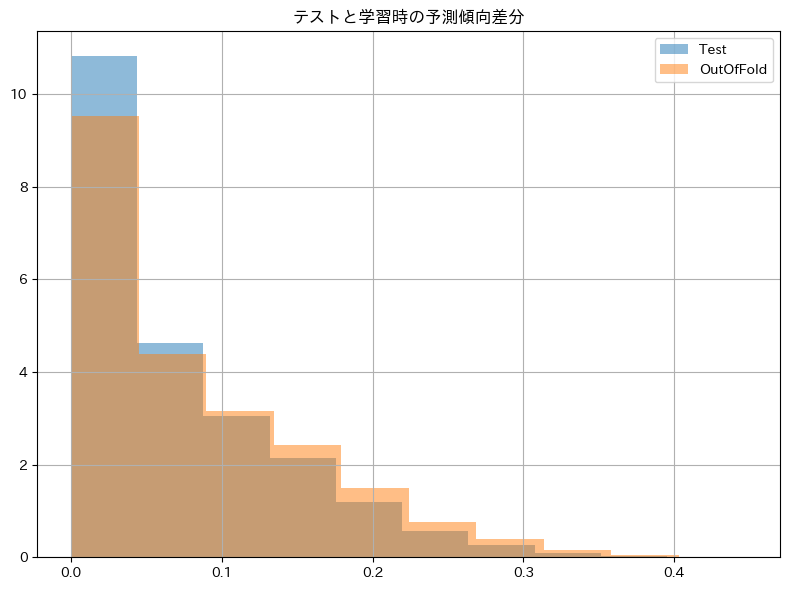

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred_prob, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("„ÉÜ„Çπ„Éà„Å®Â≠¶ÁøíÊôÇ„ÅÆ‰∫àÊ∏¨ÂÇæÂêëÂ∑ÆÂàÜ")

fig.tight_layout()

In [78]:
test_pred_df = create_top_10_yad_predict(
    predict=pred_prob, session_yad_df=test_session_yad_df
)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_").to_csv(
    f"../sub/{NOTEBOOK_NAME}_{oof_score_mapk:.4f}.csv",
    index=False,
)

In [81]:
test_pred_df

0      1      2     3      4      5  \
session_id                                                                  
00001149e9c73985425197104712478c   4523   3560  11025  4844    822   3740   
0000e02747d749a52b7736dfa751e258  13682  11705   7502   713   3866   1210   
0000f17ae2628237d78d3a38b009d3be  11192    757  13265  8304   5495   6694   
000174a6f7a569b84c5575760d2e9664  12320   5999  12341  9270   8186   1276   
00017e2a527901c9c41b1acef525d016  11512   6100  13125  7787  10817  11067   
...                                 ...    ...    ...   ...    ...    ...   
fffee3199ef94b92283239cd5e3534fa   6086   1997  11888  8496   1421    241   
ffff62c6bb49bc9c0fbcf08494a4869c   2270    445   4511   347   2035   9410   
ffff9a7dcc892875c7a8b821fa436228   3781   4096   2396  4146  12294    914   
ffffb1d30300fe17f661941fd085b04b   2074    132   2365  7165   8556   6376   
ffffe984aafd6127ce8e43e3ca40c79d   8439   6224  11505  9956   7332   9448   

                                      6      7      8      9  
session_id                                                    
00001149e9c73985425197104712478c   8050   6461  11967   1272  
0000e02747d749a52b7736dfa751e258  10016   2029  13598   5279  
0000f17ae2628237d78d3a38b009d3be   4822   6691   5559  12567  
000174a6f7a569b84c5575760d2e9664  12439   8592  12813   3305  
00017e2a527901c9c41b1acef525d016   8205   2691   4510   8280  
...                                 ...    ...    ...    ...  
fffee3199ef94b92283239cd5e3534fa    545   9630  12169   8532  
ffff62c6bb49bc9c0fbcf08494a4869c  11471   9376   1721   2917  
ffff9a7dcc892875c7a8b821fa436228   2271  12510   2280  12630  
ffffb1d30300fe17f661941fd085b04b   3558   5569   9784    642  
ffffe984aafd6127ce8e43e3ca40c79d    794   6119   8000    312  

[174700 rows x 10 columns]

## Future Work

* „Çª„ÉÉ„Ç∑„Éß„É≥„ÉªÂÆø„ÅÆÁµÑ„ÅÆÊ∑±Â†Ä„Çä
    * Â≠¶ÁøíÁî®„Éª„ÉÜ„Çπ„ÉàÁî®„ÅÆ„Çª„ÉÉ„Ç∑„Éß„É≥„Å®ÂÆø„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÅØ„Åã„Å™„Çä naive „Å™„ÇÇ„ÅÆ„ÇíÂà©Áî®„Åó„Åæ„Åó„Åü„Åå„ÄÅ„Åì„ÅÆÂÄôË£ú„ÅÆÈÅ∏„Å≥Êñπ„ÅåËâØ„ÅÑ„ÉªÊÇ™„ÅÑ„ÅßÊÄßËÉΩ„Å´Â§ß„Åç„Å™Â∑Æ„Åå„Åß„Çã„Åì„Å®„Åå‰∫àÊÉ≥„Åï„Çå„Åæ„Åô„ÄÇ‰æã„Åà„Å∞„ÉÜ„Çπ„ÉàÁî®„ÅÆÂÄôË£ú„ÅÆ‰∏≠„Å´‰∏Ä‰ª∂„ÇÇÊ≠£Ëß£„ÅÆÂÆø„ÅåÁÑ°„ÅÑ„Å®„Åô„Çã„Å®„ÄÅ„Å©„Çå„Å†„Åë‰∫àÊ∏¨ÊÄßËÉΩ„ÅåÈ´ò„ÅÑ„É¢„Éá„É´„Çí‰Ωú„Çå„Åü„Å®„Åó„Å¶„ÇÇ„Å≤„Å®„Å§„ÇÇÊ≠£Ëß£„ÇíÂΩì„Å¶„Çã„Åì„Å®„ÅØ„Åß„Åç„Åæ„Åõ„Çì„ÄÇ„Çà„ÇäËâØ„ÅÑÂÆø„ÅÆÂÄôË£ú„ÇíÈÅ∏„Å∂„Å´„ÅØ„Å©„ÅÜ„Åô„Çå„Å∞ËâØ„ÅÑ„Åã?„ÇíËÄÉ„Åà„Çã„ÅÆ„ÅØÂ§ßÂ§âÊÑèÂë≥„Åå„ÅÇ„Çä„Åù„ÅÜ„Åß„Åô„ÄÇ
* ÁâπÂæ¥Èáè„ÅÆËøΩÂä†
    * ‰ªäÂõû„ÅÆÁâπÂæ¥Èáè„ÅØ„Çª„ÉÉ„Ç∑„Éß„É≥„ÅÆÈï∑„Åï„Å®ÂÆø„ÅÆÂü∫Êú¨ÁöÑÂ±ûÊÄß„ÅÆ„Åø„Åß„Åó„Åü„ÄÇ„Åù„Çå‰ª•Â§ñ„Å´„ÇÇ„Çª„ÉÉ„Ç∑„Éß„É≥-ÂÆø„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Åã„ÇâË®àÁÆó„Åß„Åç„ÇãÁâπÂæ¥Èáè„ÅØ„ÅÇ„Çã„Åß„Åó„Çá„ÅÜ„ÄÇ„Åù„Çå„Çâ„ÇíËøΩÂä†„Åó„Å¶„Çà„ÇäÊ©üÊ¢∞Â≠¶Áøí„É¢„Éá„É´„Åå„ÅÑ„Çç„Çì„Å™ÊÉÖÂ†±„Çí‰Ωø„Åà„Çã„Çà„ÅÜ„Å´„Åô„Çã„Å®ÊÄßËÉΩ„ÅåÂêë‰∏ä„Åô„Çã„Åã„ÇÇ„Åó„Çå„Åæ„Åõ„Çì„ÄÇ
* LightGBM ‰ª•Â§ñ„ÅÆ„É¢„Éá„É´„ÅÆÊ¥ªÁî® („ÇÑ„ÇÑÈõ£„Åó„ÅÑ)
    * ‰ªäÂõû„ÅØÂàùÊâã„Å®„Åó„Å¶ÊúâËÉΩ„Å™ÂãæÈÖç„Éñ„Éº„Çπ„ÉÜ„Ç£„É≥„Ç∞„É¢„Éá„É´LightGBM„Çí„ÅîÁ¥π‰ªã„Åó„Åæ„Åó„Åü„Åå„ÄÅ„Åù„Çå‰ª•Â§ñ„Å´„ÇÇ„É¢„Éá„É´„ÅØ„Åü„Åè„Åï„ÇìÊèêÊ°à„Åï„Çå„Å¶„ÅÑ„Åæ„Åô„ÄÇ„É¨„Ç≥„É°„É≥„Éâ„ÅÆÊñáËÑà„Åß„Çà„ÅèÂá∫„Å¶„Åè„Çã„É¢„Éá„É´„ÇÑ„ÄÅ„É≠„Ç∞„Éô„Éº„Çπ„ÅÆ„Éá„Éº„Çø„Åã„Çâ‰∫àÊ∏¨„Åô„Çã„Çà„ÅÜ„Å™ÂïèÈ°å„Åß‰Ωø„Çè„Çå„Çã„É¢„Éá„É´„Å™„Å©„ÇíË©¶„Åô„ÅÆ„ÇÇËâØ„ÅÑ„Åß„Åó„Çá„ÅÜ